# NBA ALL STAR PREDICTOR

Using various statistics of a player season, the model tries to predict whether a player will be selected to the NBA All-Star game which consists of the 12 best players from each conference- Western and Eastern

A detailed explanation can be found here: https://www.basketball-reference.com/about/glossary.html

**Avg. Pace** - Pace is the total number of possessions a team uses in a game, the average is taken across all games played throughout the season <br>
**Team Conference Rank** - Where the players respective team is ranked in the conference with respect to winning percentage. <br>
**GP** - Games Played <br>
**W** - Number of games the player played in which resulted in a Win <br>
**PTS, REB, AST, STL, BLK, TOV** - Points, rebounds, assists, steals, blocks and turnovers per game, respectively <br>
**TS%** - True Shooting Percentage <br>
**3PM** - 3 pointers made per game <br>
**DEFWS** - Defensive Win Shares <br>
**USG%** - Usage Percentage <br>
**PIE** - Player Impact Estimator <br>
**Prior ASG Appearances** - Number of all star game appearances prior to the respective season <br>
**AS Last Year?** - Whether the player was selected for the all-star game the previous season <br>
**Selected?** - Whether the player was selected for the all star game in the respective season <br>

## Importing Libraries and Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
df = pd.read_csv(r"ASG_train.csv")
df2 = pd.read_csv(r"ASG_to_predict.csv")

## EDA

In [3]:
df2.isnull().sum()

Year                       0
Avg. Pace                  0
PLAYER                     0
TEAM                       0
Team Conference Rank       0
GP                         0
Team GP                    0
W                          0
PTS                        0
REB                        0
AST                        0
STL                        0
BLK                        0
TOV                        0
TS%                        0
3PM                        0
DEFWS                      0
USG%                       0
PIE                        0
Prior ASG Appearances      0
AS Last Year?              0
Selected?                454
dtype: int64

In [4]:
df2.fillna(0, inplace = True)

In [5]:
df = pd.concat([df,df2])

In [6]:
df.isnull().sum()

Year                     0
Avg. Pace                0
PLAYER                   0
TEAM                     0
Team Conference Rank     0
GP                       0
Team GP                  0
W                        0
PTS                      0
REB                      0
AST                      0
STL                      0
BLK                      0
TOV                      0
TS%                      0
3PM                      0
DEFWS                    0
USG%                     0
PIE                      0
Prior ASG Appearances    0
AS Last Year?            0
Selected?                0
dtype: int64

In [7]:
df.describe()

Year     Avg. Pace  Team Conference Rank            GP  \
count  10081.000000  10081.000000          10081.000000  10081.000000   
mean    2008.227854     93.170420              7.898621     28.269319   
std        6.809363      3.007588              4.286288     12.993259   
min     1996.000000     90.100000              1.000000      1.000000   
25%     2003.000000     90.900000              4.000000     17.000000   
50%     2008.000000     92.000000              8.000000     33.000000   
75%     2014.000000     93.900000             12.000000     39.000000   
max     2019.000000    100.300000             15.000000     48.000000   

            Team GP            W           PTS           REB           AST  \
count  10081.000000  10081.00000  10081.000000  10081.000000  10081.000000   
mean      40.426942     14.08640      8.149092      3.580934      1.796022   
std        5.726942      8.61728      6.097012      2.580322      1.820563   
min       13.000000      0.00000      0.000000      0.000000      0.000000   
25%       40.000000      7.00000      3.400000      1.700000      0.500000   
50%       41.000000     14.00000      6.600000      3.000000      1.200000   
75%       43.000000     20.00000     11.700000      4.800000      2.400000   
max       48.000000     39.00000     36.900000     16.500000     13.100000   

                STL           BLK           TOV           TS%           3PM  \
count  10081.000000  10081.000000  10081.000000  10081.000000  10081.000000   
mean       0.646741      0.423529      1.209642     50.466333      0.566452   
std        0.472073      0.502033      0.841664     11.361965      0.688202   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.300000      0.100000      0.600000     47.100000      0.000000   
50%        0.600000      0.300000      1.000000     51.900000      0.300000   
75%        0.900000      0.500000      1.700000     56.000000      1.000000   
max        3.000000      4.400000      5.800000    150.000000      5.300000   

              DEFWS          USG%           PIE  Prior ASG Appearances  \
count  10081.000000  10081.000000  10081.000000           10081.000000   
mean       0.001604     18.149449      8.154568               0.471779   
std        0.001311      5.410693      8.842835               1.680603   
min       -0.007000      0.000000   -400.000000               0.000000   
25%        0.001000     14.500000      5.900000               0.000000   
50%        0.001000     17.700000      8.500000               0.000000   
75%        0.002000     21.500000     10.900000               0.000000   
max        0.014000     66.700000    300.000000              17.000000   

       AS Last Year?     Selected?  
count   10081.000000  10081.000000  
mean        0.056740      0.059022  
std         0.231357      0.235677  
min         0.000000      0.000000  
25%         0.000000      0.000000  
50%         0.000000      0.000000  
75%         0.000000      0.000000  
max         1.000000      1.000000

Let us view the correlation of the features with the target variable:

In [8]:
df.corr()['Selected?'].sort_values()

Team Conference Rank    -0.175562
Year                    -0.009308
Avg. Pace               -0.009195
Team GP                 -0.001178
TS%                      0.129144
GP                       0.175454
PIE                      0.201541
3PM                      0.210630
BLK                      0.253219
W                        0.271040
DEFWS                    0.279059
STL                      0.331252
REB                      0.358219
AST                      0.382329
USG%                     0.384468
TOV                      0.446447
Prior ASG Appearances    0.448916
PTS                      0.538316
AS Last Year?            0.642699
Selected?                1.000000
Name: Selected?, dtype: float64

In [9]:
df.reset_index(inplace = True)

<AxesSubplot:xlabel='Year', ylabel='Avg. Pace'>

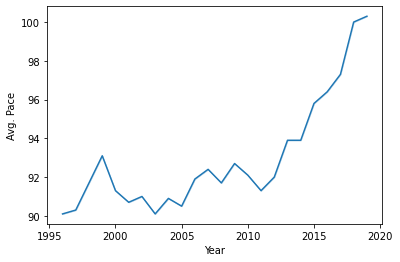

In [10]:
sns.lineplot(x='Year',y='Avg. Pace', data = df, palette = 'pastel')

In [11]:
df_allstar=df[df['Selected?']!=0]
df_nonallstar=df[df['Selected?']==0]

def dist_plot(feature,bins):
    plt.figure(figsize=(15,6))
    sns.set_palette('Set1')
    ax=sns.distplot(df_nonallstar[feature].dropna(),hist=True,kde=True,bins=bins,label='Non All-Star')
    ax=sns.distplot(df_allstar[feature].dropna(),hist=True,kde=True,bins=bins,label='All-Star')
    ax.set_xlabel(None)
    ax.legend()
    plt.title(feature,pad=20)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


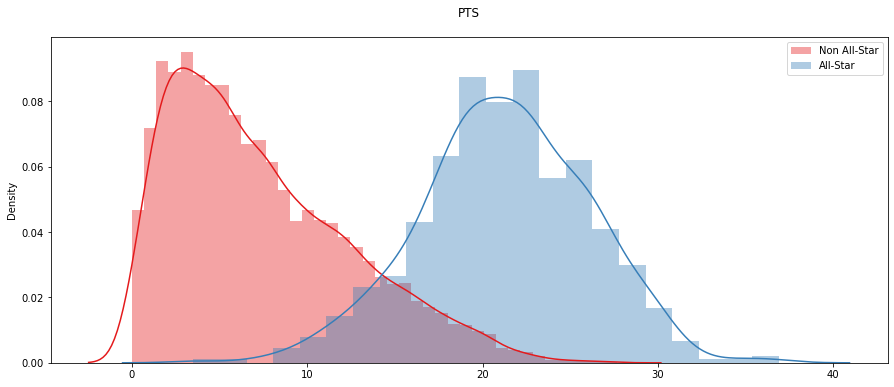

In [12]:
dist_plot('PTS',None)

We can see from the plot above that scoring has a significant impact on all-star status in the NBA.

### Extracting extra features and transforming game stats

As the years have gone by pace in the nba has significantly increased which means more possessions. More possessions means higher stats i.e. more opportunities for players to score, rebound and assist. <br>
So, we divide all the pace-dependent features (points, rebounds, assists, steals, blocks, turnovers, 3pm) by the league average pace in that season to fairly compare players from different eras.

In [13]:
df['PTS'] = df['PTS']/df['Avg. Pace']
df['AST'] = df['AST']/df['Avg. Pace']
df['REB'] = df['REB']/df['Avg. Pace']
df['BLK'] = df['BLK']/df['Avg. Pace']
df['STL'] = df['STL']/df['Avg. Pace']
df['TOV'] = df['TOV']/df['Avg. Pace']
df['3PM'] = df['3PM']/df['Avg. Pace']

We also extract a feature 'Availability' which is the percent of games the player has played in divided by the total number of games their team played. Now we can also drop games played and team games played from our dataset:

In [14]:
df['Availability'] = df['GP']/df['Team GP']

We also drop all records with less than 8 games played for the season, since these can give rise to extreme values for other game stats.

In [15]:
df.drop(df[df['GP'] <= 8].index,axis = 0, inplace = True)

In [16]:
df.drop(['GP', 'Team GP'], inplace = True, axis = 1)

<AxesSubplot:xlabel='Team Conference Rank', ylabel='Availability'>

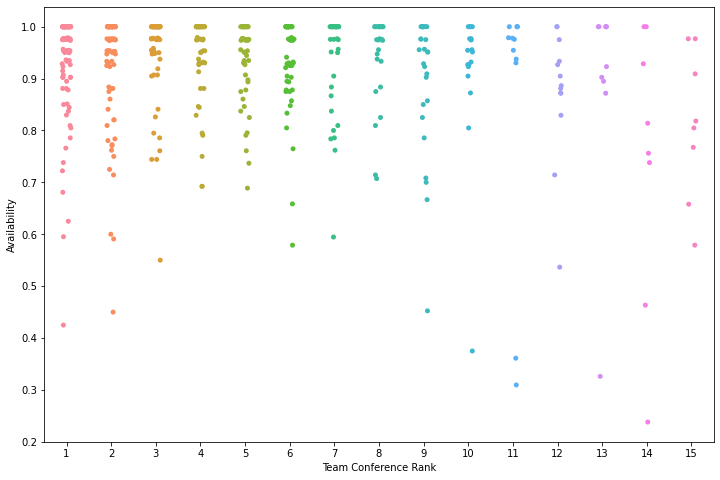

In [17]:
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(12, 8)

df1 = df[df['Selected?'] == 1]
sns.stripplot(data=df1, x="Team Conference Rank", y="Availability")

As we can see the all-stars are concentrated within an availability of 70% or greater and a team conference rank of  6 or better

### Handling outliers:

The NBA All-Star game is largely a popularity contest since fan voting is taken into account. <br>
In 2017, the NBA moved from a pure fan vote to a weighted process wherein fan voting accounts for 50%, with player and media voting account for 25% each. This is for the voting of the all star starters (the starting lineup consisting of 5 players)
NBA coaches vote for the reserves for their respective conferences, but they cannot choose players from their own team. Each coach selects two guards, three frontcourt players and two wild cards, with each selected player ranked in order of preference within each category. If a player is unavailable for the game due to injury, the NBA commissioner selects a replacement for the roster. If the replacement is for a fan-selected starter, the All-Star Game coach chooses the replacement in the starting lineup, and is not limited to the commissioner's addition to the roster. <br>
In such a case the selection process isn't always fair and can lead to certain players being overlooked for popular players like for example, Yao Ming who was selected as an all-star in 2011 despite playing only 5 games. <br>
Such cases can be removed manually:

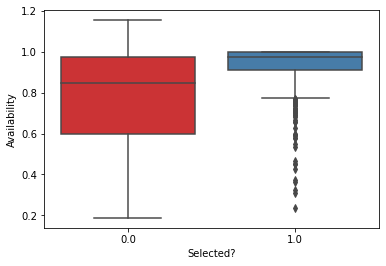

In [18]:
ax = sns.boxplot(x="Selected?", y="Availability", data=df)

From the plot above we can clearly see how important availability is to a player's selection. Using such a criteria combined with the rationale from this article: https://www.theringer.com/nba/2022/2/1/22911673/nba-all-star-game-kobe-bryant-dirk-nowitzki <br>
The Ringer is a renowned website in the world of NBA Media.

In [19]:
kobe = df[(df['PLAYER'] == 'Kobe Bryant')].tail(3).index
df.drop(kobe, inplace = True)
df[df['PLAYER'] == 'Kobe Bryant']

index  Year  Avg. Pace       PLAYER TEAM  Team Conference Rank   W  \
209     209  1996       90.1  Kobe Bryant  LAL                     3  22   
452     452  1997       90.3  Kobe Bryant  LAL                     2  28   
844     844  1999       93.1  Kobe Bryant  LAL                     1  22   
1249   1249  2000       91.3  Kobe Bryant  LAL                     3  26   
1664   1664  2001       90.7  Kobe Bryant  LAL                     2  28   
2080   2080  2002       91.0  Kobe Bryant  LAL                     9  19   
2497   2497  2003       90.1  Kobe Bryant  LAL                     4  22   
2904   2904  2004       90.9  Kobe Bryant  LAL                     6  19   
3340   3340  2005       90.5  Kobe Bryant  LAL                     7  21   
3778   3778  2006       91.9  Kobe Bryant  LAL                     5  23   
4214   4214  2007       92.4  Kobe Bryant  LAL                     3  27   
4656   4656  2008       91.7  Kobe Bryant  LAL                     1  33   
5084   5084  2009       92.7  Kobe Bryant  LAL                     1  32   
5509   5509  2010       92.1  Kobe Bryant  LAL                     2  32   
5939   5939  2011       91.3  Kobe Bryant  LAL                     6  10   

           PTS       REB       AST  ...       TOV   TS%       3PM  DEFWS  \
209   0.067703  0.018868  0.009989  ...  0.016648  52.8  0.006659  0.001   
452   0.191584  0.035437  0.026578  ...  0.019934  56.1  0.012182  0.002   
844   0.242750  0.069817  0.044039  ...  0.032223  54.1  0.007519  0.005   
1249  0.324206  0.059146  0.051479  ...  0.033954  55.8  0.013143  0.002   
1664  0.294377  0.060639  0.063947  ...  0.028666  55.9  0.006615  0.004   
2080  0.304396  0.084615  0.079121  ...  0.041758  53.3  0.012088  0.003   
2497  0.244173  0.054384  0.047725  ...  0.027747  54.3  0.009989  0.003   
2904  0.302530  0.069307  0.072607  ...  0.048405  53.9  0.020902  0.002   
3340  0.384530  0.061878  0.047514  ...  0.033149  54.5  0.018785  0.002   
3778  0.303591  0.057671  0.060936  ...  0.035909  58.8  0.016322  0.002   
4214  0.296537  0.062771  0.055195  ...  0.033550  56.2  0.020563  0.004   
4656  0.292257  0.062159  0.056707  ...  0.032715  56.8  0.014177  0.003   
5084  0.306365  0.056095  0.048544  ...  0.031284  54.3  0.012945  0.004   
5509  0.271444  0.055375  0.052117  ...  0.031488  55.5  0.014115  0.002   
5939  0.332968  0.060241  0.062432  ...  0.040526  54.0  0.013143  0.008   

      USG%   PIE  Prior ASG Appearances  AS Last Year?  Selected?  \
209   25.5   7.8                      0              0        0.0   
452   27.8  13.4                      0              0        1.0   
844   26.2  14.4                      1              1        1.0   
1249  31.2  16.0                      2              1        1.0   
1664  30.5  17.9                      3              1        1.0   
2080  30.8  18.5                      4              1        1.0   
2497  26.7  13.8                      5              1        1.0   
2904  31.8  14.8                      6              1        1.0   
3340  38.2  18.1                      7              1        1.0   
3778  30.6  16.1                      8              1        1.0   
4214  31.6  16.5                      9              1        1.0   
4656  31.3  16.1                     10              1        1.0   
5084  33.0  15.4                     11              1        1.0   
5509  33.6  15.5                     12              1        1.0   
5939  37.4  18.2                     13              1        1.0   

      Availability  
209       0.780488  
452       0.925000  
844       0.625000  
1249      1.000000  
1664      1.000000  
2080      1.000000  
2497      0.846154  
2904      0.894737  
3340      0.950000  
3778      0.926829  
4214      1.000000  
4656      1.000000  
5084      1.000000  
5509      1.000000  
5939      1.000000  

[15 rows x 22 columns]

In [20]:
df.drop(df[(df['PLAYER'] == 'Dirk Nowitzki')].tail(1).index, inplace = True)
df.drop(df[(df['PLAYER'] == 'Dwyane Wade')].tail(1).index, inplace = True)
df.drop(df[df['PLAYER'] == 'Yao Ming'].tail(1).index, inplace = True)
df.drop(df[(df['PLAYER'] == 'Grant Hill') & (df['Year'] == 2000)].index, inplace = True)
df.drop(df[(df['PLAYER'] == 'Allen Iverson') & (df['Year'] == 2009)].index, inplace = True)
df.drop(df[(df['PLAYER'] == 'Alonzo Mourning') & (df['Year'] == 2000)].index, inplace = True)
df.drop(df[(df['PLAYER'] == 'Anfernee Hardaway') & (df['Year'] == 1997)].index, inplace = True)
df.drop(df[(df['PLAYER'] == "Shaquille O'Neal") & (df['Year'] == 1997)].index, inplace = True)

<AxesSubplot:xlabel='Selected?', ylabel='count'>

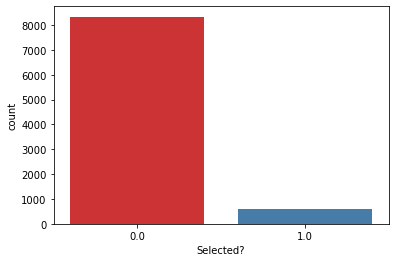

In [21]:
sns.countplot(data = df, x = 'Selected?')

In [22]:
df['Selected?'].value_counts()

0.0    8333
1.0     582
Name: Selected?, dtype: int64

In [23]:
df.drop('index', axis = 1, inplace = True)

## Feature Selection

In [24]:
df

Year  Avg. Pace               PLAYER TEAM  Team Conference Rank   W  \
0      1996       90.1       Michael Jordan  CHI                     1  35   
1      1996       90.1     Shaquille O'Neal  LAL                     3  28   
2      1996       90.1     Latrell Sprewell  GSW                     7  16   
3      1996       90.1          Karl Malone  UTA                     4  27   
4      1996       90.1      Hakeem Olajuwon  HOU                     1  28   
...     ...        ...                  ...  ...                   ...  ..   
10047  2019      100.3        Rayjon Tucker  UTA                     3   9   
10055  2019      100.3       Malcolm Miller  TOR                     3  18   
10056  2019      100.3      Amile Jefferson  ORL                     7   5   
10063  2019      100.3         Juwan Morgan  UTA                     3   7   
10064  2019      100.3  Nigel Williams-Goss  UTA                     3   5   

            PTS       REB       AST       STL  ...       TOV   TS%       3PM  \
0      0.342952  0.064373  0.044395  0.017758  ...  0.018868  56.4  0.013319   
1      0.290788  0.146504  0.035516  0.009989  ...  0.034406  55.7  0.000000   
2      0.287458  0.054384  0.067703  0.019978  ...  0.044395  57.1  0.024417   
3      0.286349  0.119867  0.052164  0.014428  ...  0.034406  57.6  0.000000   
4      0.267481  0.104329  0.029967  0.016648  ...  0.041065  54.8  0.001110   
...         ...       ...       ...       ...  ...       ...   ...       ...   
10047  0.010967  0.008973  0.001994  0.000997  ...  0.000997  36.2  0.000000   
10055  0.009970  0.006979  0.003988  0.001994  ...  0.000997  44.2  0.001994   
10056  0.008973  0.013958  0.002991  0.000000  ...  0.001994  38.3  0.000000   
10063  0.003988  0.005982  0.000997  0.000000  ...  0.001994  40.0  0.000000   
10064  0.003988  0.005982  0.005982  0.000997  ...  0.001994  25.4  0.000000   

       DEFWS  USG%   PIE  Prior ASG Appearances  AS Last Year?  Selected?  \
0      0.004  33.6  19.8                     10              1        1.0   
1      0.003  30.4  18.4                      4              1        1.0   
2      0.001  28.2  14.5                      2              0        1.0   
3      0.003  31.5  20.8                      9              1        1.0   
4      0.003  32.2  16.3                     11              1        1.0   
...      ...   ...   ...                    ...            ...        ...   
10047  0.000  10.3   2.4                      0              0        0.0   
10055  0.001   8.9   3.3                      0              0        0.0   
10056  0.001  12.6   4.8                      0              0        0.0   
10063  0.001   8.1   3.0                      0              0        0.0   
10064  0.001  14.1   5.0                      0              0        0.0   

       Availability  
0          1.000000  
1          0.975610  
2          1.000000  
3          1.000000  
4          0.902439  
...             ...  
10047      0.232558  
10055      0.488372  
10056      0.340909  
10063      0.209302  
10064      0.209302  

[8915 rows x 21 columns]

In [25]:
df.drop(['PLAYER','TEAM','Year','Avg. Pace'], axis = 1, inplace = True)

In [26]:
X = df.drop('Selected?', axis = 1)
y = df['Selected?']

We are going to be using a hyperparameter optimised lightgbm model for feature selection

In [27]:
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 1, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [28]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=100)

[I 2022-07-29 11:47:26,694] A new study created in memory with name: LGBM Classifier
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.1957227765580996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.1957227765580996
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.1957227765580996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.1957227765580996
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 741 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 742 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 743 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 744 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 745 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.1957227765580996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.1957227765580996
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.1957227765580996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.1957227765580996
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.1957227765580996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.1957227765580996
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 529 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=2.497699903987032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.497699903987032
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=2.497699903987032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.497699903987032
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Wa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=8.109882571051031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.109882571051031
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=0.513852224055627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.513852224055627
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=630

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] min_gain_to_split is set=7.413333158754003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.413333158754003
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=560

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] min_gain_to_split is set=7.413333158754003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.413333158754003
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ign

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=9.08450251162936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.08450251162936
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=9.08450251162936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.08450251162936
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] min_gain_to_split is set=11.210117237119945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.210117237119945
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Wa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is igno

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] min_gain_to_split is set=11.210117237119945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.210117237119945
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Wa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] min_gain_to_split is set=13.729891428846908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.729891428846908
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] min_gain_to_split is set=13.729891428846908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.729891428846908
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] min_gain_to_split is set=13.729891428846908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.729891428846908
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Wa

[I 2022-07-29 11:47:31,233] Trial 8 pruned. Trial was pruned at iteration 101.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=5.984587144336091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.984587144336091
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=5.984587144336091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.984587144336091
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.605455325289514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.605455325289514
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.605455325289514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.605455325289514
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=4.605455325289514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.605455325289514
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=2.719553072402652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.719553072402652
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=2.719553072402652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.719553072402652
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=2.719553072402652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.719553072402652
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=3.4928345727026016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4928345727026016
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Curre

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ign

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=3.4928345727026016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4928345727026016
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=3.4928345727026016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4928345727026016
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: featu

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is

[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.7264238343499247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7264238343499247
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.300

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.7264238343499247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7264238343499247
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM]

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is igno

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=5.396293987680764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.396293987680764
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=5.396293987680764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.396293987680764
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=5.396293987680764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.396293987680764
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:47:35,001] Trial 15 pruned. Trial was pruned at iteration 101.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_st

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=2.5002309644708047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5002309644708047
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=6.56361170173254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.56361170173254
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=330

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=6.56361170173254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.56361170173254
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=330

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=5.117253291584529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.117253291584529
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=5.117253291584529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.117253291584529
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=5.117253291584529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.117253291584529
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:47:36,496] Trial 18 pruned. Trial was pruned at iteration 101.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=11.365680749908183, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.365680749908183
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=7.017403585115433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.017403585115433
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=7.017403585115433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.017403585115433
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=4.097604463418044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.097604463418044
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=4.097604463418044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.097604463418044
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=4.097604463418044, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.097604463418044
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=6.039478041431071, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.039478041431071
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=6.039478041431071, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.039478041431071
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=6.039478041431071, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.039478041431071
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=7.668324082564209, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.668324082564209
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is se

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=7.668324082564209, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.668324082564209
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=9.568381786514145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.568381786514145
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-07-29 11:47:39,247] Trial 23 pruned. Trial was pruned at iteration 359.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:47:39,424] Trial 24 pruned. Trial was pruned at iteration 101.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\Program

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=8.533335553280173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.533335553280173
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=8.533335553280173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.533335553280173
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=10.415550658108902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.415550658108902
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=10.415550658108902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.415550658108902
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is 

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
[I 2022-07-29 11:47:40,548] Trial 26 finished with value: 0.2412639281446872 and parameters: {'n_estimators': 7809, 'learning_rate': 0.10927034539003277, 'num_leaves': 400, 'max_depth': 8, 'min_data_in_leaf': 3800, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 10.415550658108902, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.08689838278845442.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.p

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=10.415550658108902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.415550658108902
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=6.004904174114197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.004904174114197
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=6.004904174114197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.004904174114197
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is se

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=6.004904174114197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.004904174114197
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] min_gain_to_split is set=7.981024155037167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.981024155037167
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] min_gain_to_split is set=7.981024155037167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.981024155037167
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=11.175484928513779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.175484928513779
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=11.175484928513779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.175484928513779
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=11.175484928513779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.175484928513779
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=14.951133484856967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.951133484856967
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=14.951133484856967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.951133484856967
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=14.951133484856967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.951133484856967
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] min_gain_to_split is set=10.410923983774921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.410923983774921
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=10.410923983774921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is igno

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] min_gain_to_split is set=10.410923983774921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.410923983774921
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=10.410923983774921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=10.410923983774921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.410923983774921
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=12.619936488776512, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.619936488776512
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=12.619936488776512, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.619936488776512
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is se

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=12.619936488776512, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.619936488776512
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=13.430168339998351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.430168339998351
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=13.430168339998351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.430168339998351
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=12.790039936768807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.790039936768807
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=12.790039936768807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.790039936768807
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=12.790039936768807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.790039936768807
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=12.742175222551415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.742175222551415
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=12.742175222551415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.742175222551415
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] min_gain_to_split is set=12.550247410110797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.550247410110797
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] min_gain_to_split is set=12.550247410110797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.550247410110797
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] min_gain_to_split is set=12.550247410110797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.550247410110797
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=6.817198565953657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.817198565953657
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Curr

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=6.817198565953657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.817198565953657
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Curr

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=1.5882980768220616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5882980768220616
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=1.5882980768220616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5882980768220616
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=1.5882980768220616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5882980768220616
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=8.639588015969316, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.639588015969316
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=8.639588015969316, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.639588015969316
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=8.639588015969316, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.639588015969316
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:47:48,277] Trial 40 pruned. Trial was pruned at iteration 101.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_st

[LightGBM] [Warning] min_gain_to_split is set=7.844834610327343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.844834610327343
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=8.831848300735428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.831848300735428
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=8.831848300735428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.831848300735428
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=10.348235896976517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.348235896976517
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=10.348235896976517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.348235896976517
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=10.348235896976517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.348235896976517
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=7.567630387481118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.567630387481118
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is se

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=7.567630387481118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.567630387481118
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is se

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=7.567630387481118, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.567630387481118
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=5.836064515140546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.836064515140546
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=5.836064515140546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.836064515140546
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=5.836064515140546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.836064515140546
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=8.49097767997229, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.49097767997229
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.60000

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=8.49097767997229, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.49097767997229
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.60000

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=8.49097767997229, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.49097767997229
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.60000

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=4.844341340056312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.844341340056312
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Wa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=4.844341340056312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.844341340056312
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=4.844341340056312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.844341340056312
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=9.497528935455826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.497528935455826
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=9.497528935455826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.497528935455826
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=9.497528935455826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.497528935455826
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=11.28069443955551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.28069443955551
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=640

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=11.28069443955551, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.28069443955551
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=640

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=6.307903956549975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.307903956549975
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Wa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=6.307903956549975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.307903956549975
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Wa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=6.307903956549975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.307903956549975
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=10.465650329789895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.465650329789895
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=10.465650329789895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.465650329789895
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=10.465650329789895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.465650329789895
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=13.884028666873684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.884028666873684
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=13.884028666873684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.884028666873684
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=13.884028666873684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.884028666873684
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=11.769703765057603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.769703765057603
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=11.769703765057603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.769703765057603
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=11.769703765057603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.769703765057603
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=14.82993863653347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.82993863653347
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=670

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=14.82993863653347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.82993863653347
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=670

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=14.82993863653347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.82993863653347
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=14.935831895029326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.935831895029326
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=14.935831895029326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.935831895029326
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=14.935831895029326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.935831895029326
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=13.904895711209685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.904895711209685
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=13.904895711209685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.904895711209685
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=13.904895711209685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.904895711209685
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=12.174697537440656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.174697537440656
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=12.174697537440656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.174697537440656
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=12.174697537440656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.174697537440656
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=13.132872271917748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.132872271917748
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=13.132872271917748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.132872271917748
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=13.132872271917748, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.132872271917748
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=14.410371521197764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.410371521197764
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=14.410371521197764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.410371521197764
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=14.410371521197764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.410371521197764
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=13.222631262372074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.222631262372074
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=13.222631262372074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.222631262372074
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=13.222631262372074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.222631262372074
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=12.723919065788365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.723919065788365
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=12.723919065788365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.723919065788365
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=12.723919065788365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.723919065788365
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=12.34083882527084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.34083882527084
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Wa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=12.34083882527084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.34083882527084
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Wa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=12.34083882527084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.34083882527084
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] min_gain_to_split is set=13.367409688655405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.367409688655405
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] min_gain_to_split is set=13.367409688655405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.367409688655405
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] min_gain_to_split is set=13.367409688655405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.367409688655405
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=1.4145383233912125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4145383233912125
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=1.4145383233912125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4145383233912125
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
[I 2022-07-29 11:48:03,301] Trial 63 finished with value: 0.2412639281446872 and parameters: {'n_estimators': 5549, 'learning_rate': 0.14266805740159105, 'num_leaves': 2680, 'max_depth': 6, 'min_data_in_leaf': 2600, 'lambda_l1': 10, 'lambda_l2': 85, 'min_gain_to_split': 1.4145383233912125, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.08689838278845442.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=1.4145383233912125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4145383233912125
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.8712121553557912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8712121553557912
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.8712121553557912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8712121553557912
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 403 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 404 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 548 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 549 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 550 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 551 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 690 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 691 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 692 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 693 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 694 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.8712121553557912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8712121553557912
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 484 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 485 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 486 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 487 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 488 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 618 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 619 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 620 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 621 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 622 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 745 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 746 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 747 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 748 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 749 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.8712121553557912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8712121553557912
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 534 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 673 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 674 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 675 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 676 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 677 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.8712121553557912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8712121553557912
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 499 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 501 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 635 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 636 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 637 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 638 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 639 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 775 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 776 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 777 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 778 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 779 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 909 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 910 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 911 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 912 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 913 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becaus

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:48:09,623] Trial 65 pruned. Trial was pruned at iteration 101.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.17132192968148607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.17132192968148607
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] min_gain_to_split is set=2.9862685541950578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9862685541950578
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] min_gain_to_split is set=2.9862685541950578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9862685541950578
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:48:10,629] Trial 67 pruned. Trial was pruned at iteration 101.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.115961773177866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.115961773177866
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:48:10,855] Trial 68 pruned. Trial was pruned at iteration 101.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_st

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=6.971663963326232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.971663963326232
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=6.971663963326232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.971663963326232
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:48:11,901] Trial 70 pruned. Trial was pruned at iteration 116.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.873268316241257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.873268316241257
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=5.69368803609092, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.69368803609092
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=5.69368803609092, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.69368803609092
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:48:12,915] Trial 72 pruned. Trial was pruned at iteration 101.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=9.850509231872648, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.850509231872648
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=6.935671414946695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.935671414946695
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=6.935671414946695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.935671414946695
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=7.287905706820583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.287905706820583
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=7.287905706820583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.287905706820583
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=7.287905706820583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.287905706820583
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=4.8392749775999055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8392749775999055
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Cur

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=4.8392749775999055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8392749775999055
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Cur

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ig

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=4.8392749775999055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8392749775999055
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=6.433879754391142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.433879754391142
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ig

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=6.433879754391142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.433879754391142
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=6.433879754391142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.433879754391142
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=9.408661322948834, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.408661322948834
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=9.408661322948834, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.408661322948834
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=9.408661322948834, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.408661322948834
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] min_gain_to_split is set=4.386394701128934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.386394701128934
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] min_gain_to_split is set=4.386394701128934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.386394701128934
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ig

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] min_gain_to_split is set=4.386394701128934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.386394701128934
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=9.386738828056517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.386738828056517
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=9.386738828056517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.386738828056517
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=9.386738828056517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.386738828056517
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=14.424247166409621, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.424247166409621
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=14.424247166409621, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.424247166409621
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is depreca

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=14.424247166409621, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.424247166409621
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.757559575660192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.757559575660192
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.757559575660192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.757559575660192
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.757559575660192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.757559575660192
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=14.040826604780257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.040826604780257
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=14.040826604780257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.040826604780257
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=14.040826604780257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.040826604780257
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=14.82727356817571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.82727356817571
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=740

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=14.82727356817571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.82727356817571
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=740

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=14.82727356817571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.82727356817571
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=13.75733964902184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.75733964902184
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=820

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=13.75733964902184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.75733964902184
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=820

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ig

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=13.75733964902184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.75733964902184
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=12.044014998425013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.044014998425013
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=730

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=12.044014998425013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.044014998425013
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=730

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ign

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=12.044014998425013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.044014998425013
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=14.480071856833908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.480071856833908
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=14.480071856833908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.480071856833908
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=14.480071856833908, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.480071856833908
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=14.23603061555856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.23603061555856
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=14.23603061555856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.23603061555856
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=14.23603061555856, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.23603061555856
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=13.195657410940283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.195657410940283
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=780

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=13.195657410940283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.195657410940283
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=780

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=13.195657410940283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.195657410940283
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The report

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=12.993646918672932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.993646918672932
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=12.993646918672932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.993646918672932
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is igno

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=12.993646918672932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.993646918672932
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=12.33160955103493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.33160955103493
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=12.33160955103493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.33160955103493
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignore

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=12.33160955103493, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.33160955103493
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] min_gain_to_split is set=14.052521953510976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.052521953510976
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] min_gain_to_split is set=14.052521953510976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.052521953510976
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] min_gain_to_split is set=14.052521953510976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.052521953510976
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=13.168785391096455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.168785391096455
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=13.168785391096455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.168785391096455
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warn

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=13.168785391096455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.168785391096455
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=12.350729747261298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.350729747261298
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=12.350729747261298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.350729747261298
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=12.350729747261298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.350729747261298
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] min_gain_to_split is set=0.9435374998862072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9435374998862072
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] min_gain_to_split is set=0.9435374998862072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9435374998862072
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] min_gain_to_split is set=0.9435374998862072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9435374998862072
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=2.934144217130838, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.934144217130838
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=2.934144217130838, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.934144217130838
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=2.934144217130838, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.934144217130838
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=1.7624166341922805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7624166341922805
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=1.7624166341922805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7624166341922805
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=1.7624166341922805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7624166341922805
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] min_gain_to_split is set=2.9452822018939204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9452822018939204
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] min_gain_to_split is set=2.9452822018939204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9452822018939204
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] min_gain_to_split is set=2.9452822018939204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9452822018939204
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:48:31,444] Trial 98 pruned. Trial was pruned at iteration 101.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3.6749132581803887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6749132581803887
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-pa

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=5.369281132997094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.369281132997094
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because thi

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=5.369281132997094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.369281132997094
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

In [29]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.07079
	Best params:
		n_estimators: 2451
		learning_rate: 0.1229450028076184
		num_leaves: 1620
		max_depth: 5
		min_data_in_leaf: 700
		lambda_l1: 10
		lambda_l2: 75
		min_gain_to_split: 1.8712121553557912
		bagging_fraction: 0.5
		bagging_freq: 1
		feature_fraction: 0.2


In [30]:
featuremodel = lgb.LGBMClassifier(n_estimators=2451, learning_rate = 0.1229450028076184, num_leaves = 1620, max_depth = 5, 
                                  min_data_in_leaf = 700, lambda_l1 = 10, lambda_l2 = 75, 
                                  min_gain_to_split = 1.8712121553557912,
                                 bagging_fraction = 0.5, bagging_freq = 1, feature_fraction = 0.2)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5)

In [32]:
featuremodel.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)])

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.8712121553557912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8712121553557912
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	training's binary_logloss: 0.238845	valid_0's binary_logloss: 0.239217
[2]	training's binary_logloss: 0.227686	valid_0's binary_logloss: 0.227816
[3]	training's binar

[378]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[379]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[380]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[381]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[382]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[383]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[384]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[385]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[386]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[387]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[388]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[389]	training's binary_logloss: 0.0690697	valid_0's binary_logloss: 0.0601795
[390]	training's binary_logloss: 0.0690697	valid_0's

[814]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[815]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[816]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[817]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[818]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[819]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[820]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[821]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[822]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[823]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[824]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[825]	training's binary_logloss: 0.0676765	valid_0's binary_logloss: 0.0584897
[826]	training's binary_logloss: 0.0676765	valid_0's

[1253]	training's binary_logloss: 0.0673408	valid_0's binary_logloss: 0.0581401
[1254]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1255]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1256]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1257]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1258]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1259]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1260]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1261]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1262]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1263]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1264]	training's binary_logloss: 0.0672735	valid_0's binary_logloss: 0.0580696
[1265]	training's binary_logloss: 0.0672

[1717]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1718]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1719]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1720]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1721]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1722]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1723]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1724]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1725]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1726]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1727]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1728]	training's binary_logloss: 0.0669393	valid_0's binary_logloss: 0.0577078
[1729]	training's binary_logloss: 0.0669

[2125]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2126]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2127]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2128]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2129]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2130]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2131]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2132]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2133]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2134]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2135]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2136]	training's binary_logloss: 0.0667619	valid_0's binary_logloss: 0.0575016
[2137]	training's binary_logloss: 0.0667

LGBMClassifier(bagging_fraction=0.5, bagging_freq=1, feature_fraction=0.2,
               lambda_l1=10, lambda_l2=75, learning_rate=0.1229450028076184,
               max_depth=5, min_data_in_leaf=700,
               min_gain_to_split=1.8712121553557912, n_estimators=2451,
               num_leaves=1620)

In [37]:
print(classification_report(y_val,featuremodel.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       834
         1.0       0.80      0.67      0.73        58

    accuracy                           0.97       892
   macro avg       0.89      0.83      0.86       892
weighted avg       0.97      0.97      0.97       892



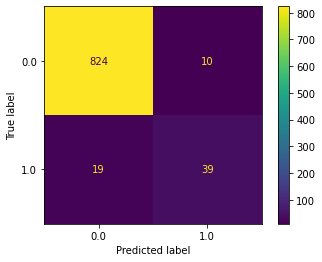

In [38]:
cm = sk.metrics.confusion_matrix(y_val, featuremodel.predict(X_val), labels=None, sample_weight=None, normalize=None)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=featuremodel.classes_)
disp.plot()
plt.show()

As we can see from the above featuremodel, it is able to detect a good amount of true postives. We can move forward and take the important features from this model

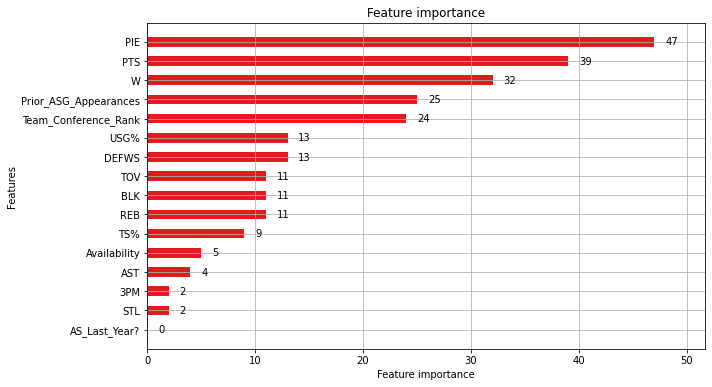

In [39]:
feature_imp_plot = lgb.plot_importance(featuremodel, ignore_zero = False, height = 0.5, figsize = (10,6))

Using the feature importance plot we will be dropping the 'TS%', 'STL', '3PM', 'AS Last Year?' features from our final model. <br>
From our visualisations it was clear that 'Availability' had an impact on the selection of all stars so we will be keeping that in our final model. <br>
True Shooting percentage is inversely proportional to the number of shot attempts a player takes. There are more players who play and shoot considerably less in games than there are all-stars. This will skew the value of TS%. That is why we'll be removing it from the model. <br>

In [36]:
df.drop(['TS%', 'STL', '3PM', 'AS Last Year?'], axis = 1, inplace = True)

## Building our final model: ANN using Tensorflow

In [41]:
df

Team Conference Rank   W       PTS       REB       AST       BLK  \
0                         1  35  0.342952  0.064373  0.044395  0.005549   
1                         3  28  0.290788  0.146504  0.035516  0.034406   
2                         7  16  0.287458  0.054384  0.067703  0.008879   
3                         4  27  0.286349  0.119867  0.052164  0.007769   
4                         1  28  0.267481  0.104329  0.029967  0.024417   
...                     ...  ..       ...       ...       ...       ...   
10047                     3   9  0.010967  0.008973  0.001994  0.000000   
10055                     3  18  0.009970  0.006979  0.003988  0.000997   
10056                     7   5  0.008973  0.013958  0.002991  0.001994   
10063                     3   7  0.003988  0.005982  0.000997  0.000997   
10064                     3   5  0.003988  0.005982  0.005982  0.000997   

            TOV  DEFWS  USG%   PIE  Prior ASG Appearances  Selected?  \
0      0.018868  0.004  33.6  19.8                     10        1.0   
1      0.034406  0.003  30.4  18.4                      4        1.0   
2      0.044395  0.001  28.2  14.5                      2        1.0   
3      0.034406  0.003  31.5  20.8                      9        1.0   
4      0.041065  0.003  32.2  16.3                     11        1.0   
...         ...    ...   ...   ...                    ...        ...   
10047  0.000997  0.000  10.3   2.4                      0        0.0   
10055  0.000997  0.001   8.9   3.3                      0        0.0   
10056  0.001994  0.001  12.6   4.8                      0        0.0   
10063  0.001994  0.001   8.1   3.0                      0        0.0   
10064  0.001994  0.001  14.1   5.0                      0        0.0   

       Availability  
0          1.000000  
1          0.975610  
2          1.000000  
3          1.000000  
4          0.902439  
...             ...  
10047      0.232558  
10055      0.488372  
10056      0.340909  
10063      0.209302  
10064      0.209302  

[8915 rows x 13 columns]

In [42]:
from tensorflow.keras.layers import Dropout

In [43]:
X_train.shape

(7132, 16)

For the first iteration we are going to try without any Dropout or Early Stopping to analyse the behavior.

In [44]:
model = Sequential()
model.add(Dense(16,activation = 'relu'))
model.add(Dense(8,activation = 'relu'))
model.add(Dense(4,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy',optimizer = 'adam')

In [45]:
model.fit(x=X_train,y=y_train,epochs=400,validation_data =(X_val,y_val))

Epoch 1/400
223/223 [==============================] - 1s 2ms/step - loss: 0.1549 - val_loss: 0.1267
Epoch 2/400
223/223 [==============================] - 0s 1ms/step - loss: 0.1079 - val_loss: 0.1103
Epoch 3/400
223/223 [==============================] - 0s 1ms/step - loss: 0.0969 - val_loss: 0.1021
Epoch 4/400
223/223 [==============================] - 0s 1ms/step - loss: 0.0936 - val_loss: 0.0980
Epoch 5/400
223/223 [==============================] - 0s 1ms/step - loss: 0.0907 - val_loss: 0.1022
Epoch 6/400
223/223 [==============================] - 0s 1ms/step - loss: 0.0896 - val_loss: 0.0971
Epoch 7/400
223/223 [==============================] - 0s 931us/step - loss: 0.0861 - val_loss: 0.0875
Epoch 8/400
223/223 [==============================] - 0s 935us/step - loss: 0.0889 - val_loss: 0.0869
Epoch 9/400
223/223 [==============================] - 0s 894us/step - loss: 0.0845 - val_loss: 0.0944
Epoch 10/400
223/223 [==============================] - 0s 912us/step - loss: 0.0850 

223/223 [==============================] - 0s 925us/step - loss: 0.0679 - val_loss: 0.0774
Epoch 81/400
223/223 [==============================] - 0s 895us/step - loss: 0.0690 - val_loss: 0.0760
Epoch 82/400
223/223 [==============================] - 0s 867us/step - loss: 0.0678 - val_loss: 0.0752
Epoch 83/400
223/223 [==============================] - 0s 903us/step - loss: 0.0698 - val_loss: 0.0782
Epoch 84/400
223/223 [==============================] - 0s 908us/step - loss: 0.0685 - val_loss: 0.0725
Epoch 85/400
223/223 [==============================] - 0s 885us/step - loss: 0.0679 - val_loss: 0.0812
Epoch 86/400
223/223 [==============================] - 0s 864us/step - loss: 0.0700 - val_loss: 0.0767
Epoch 87/400
223/223 [==============================] - 0s 899us/step - loss: 0.0677 - val_loss: 0.0720
Epoch 88/400
223/223 [==============================] - 0s 888us/step - loss: 0.0684 - val_loss: 0.0748
Epoch 89/400
223/223 [==============================] - 0s 947us/step - loss:

223/223 [==============================] - ETA: 0s - loss: 0.060 - 0s 925us/step - loss: 0.0614 - val_loss: 0.0770
Epoch 159/400
223/223 [==============================] - 0s 835us/step - loss: 0.0623 - val_loss: 0.0673
Epoch 160/400
223/223 [==============================] - 0s 845us/step - loss: 0.0602 - val_loss: 0.0692
Epoch 161/400
223/223 [==============================] - 0s 884us/step - loss: 0.0602 - val_loss: 0.0668
Epoch 162/400
223/223 [==============================] - 0s 876us/step - loss: 0.0606 - val_loss: 0.0810
Epoch 163/400
223/223 [==============================] - 0s 858us/step - loss: 0.0620 - val_loss: 0.0666
Epoch 164/400
223/223 [==============================] - 0s 883us/step - loss: 0.0607 - val_loss: 0.0684
Epoch 165/400
223/223 [==============================] - 0s 862us/step - loss: 0.0601 - val_loss: 0.0790
Epoch 166/400
223/223 [==============================] - 0s 851us/step - loss: 0.0623 - val_loss: 0.0664
Epoch 167/400
223/223 [======================

223/223 [==============================] - 0s 899us/step - loss: 0.0572 - val_loss: 0.0754
Epoch 237/400
223/223 [==============================] - 0s 1ms/step - loss: 0.0579 - val_loss: 0.0680
Epoch 238/400
223/223 [==============================] - 0s 938us/step - loss: 0.0579 - val_loss: 0.0779
Epoch 239/400
223/223 [==============================] - 0s 913us/step - loss: 0.0570 - val_loss: 0.0661
Epoch 240/400
223/223 [==============================] - 0s 941us/step - loss: 0.0574 - val_loss: 0.0692
Epoch 241/400
223/223 [==============================] - 0s 945us/step - loss: 0.0594 - val_loss: 0.0722
Epoch 242/400
223/223 [==============================] - 0s 877us/step - loss: 0.0588 - val_loss: 0.0673
Epoch 243/400
223/223 [==============================] - 0s 1ms/step - loss: 0.0560 - val_loss: 0.0662
Epoch 244/400
223/223 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.0691
Epoch 245/400
223/223 [==============================] - 0s 1ms/step - loss

223/223 [==============================] - 0s 900us/step - loss: 0.0557 - val_loss: 0.0632
Epoch 315/400
223/223 [==============================] - 0s 859us/step - loss: 0.0566 - val_loss: 0.0638
Epoch 316/400
223/223 [==============================] - 0s 812us/step - loss: 0.0542 - val_loss: 0.0638
Epoch 317/400
223/223 [==============================] - 0s 811us/step - loss: 0.0543 - val_loss: 0.0644
Epoch 318/400
223/223 [==============================] - 0s 846us/step - loss: 0.0549 - val_loss: 0.0625
Epoch 319/400
223/223 [==============================] - 0s 865us/step - loss: 0.0550 - val_loss: 0.0894
Epoch 320/400
223/223 [==============================] - 0s 842us/step - loss: 0.0566 - val_loss: 0.0639
Epoch 321/400
223/223 [==============================] - 0s 933us/step - loss: 0.0553 - val_loss: 0.0645
Epoch 322/400
223/223 [==============================] - 0s 914us/step - loss: 0.0548 - val_loss: 0.0659
Epoch 323/400
223/223 [==============================] - 0s 897us/ste

223/223 [==============================] - 0s 917us/step - loss: 0.0534 - val_loss: 0.0710
Epoch 393/400
223/223 [==============================] - 0s 873us/step - loss: 0.0545 - val_loss: 0.0701
Epoch 394/400
223/223 [==============================] - 0s 889us/step - loss: 0.0533 - val_loss: 0.0673
Epoch 395/400
223/223 [==============================] - 0s 869us/step - loss: 0.0560 - val_loss: 0.0728
Epoch 396/400
223/223 [==============================] - 0s 875us/step - loss: 0.0551 - val_loss: 0.0630
Epoch 397/400
223/223 [==============================] - 0s 907us/step - loss: 0.0545 - val_loss: 0.0624
Epoch 398/400
223/223 [==============================] - 0s 880us/step - loss: 0.0538 - val_loss: 0.0657
Epoch 399/400
223/223 [==============================] - 0s 883us/step - loss: 0.0570 - val_loss: 0.0640
Epoch 400/400
223/223 [==============================] - 0s 885us/step - loss: 0.0534 - val_loss: 0.0598


In [46]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

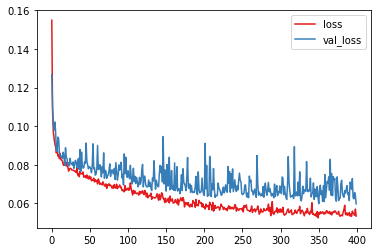

In [47]:
losses.plot()

By adding in early stopping it should have better performance:

In [62]:
model1 = Sequential()
model1.add(Dense(16,activation = 'relu'))
model1.add(Dense(8,activation = 'relu'))
model1.add(Dense(4,activation = 'relu'))
model1.add(Dense(1,activation = 'sigmoid'))
model1.compile(loss = 'binary_crossentropy',optimizer = 'adam')

In [63]:
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
early_stop = EarlyStopping(monitor = 'val_loss',mode='min',verbose = 1,patience = 75)

In [65]:
model1.fit(x=X_train,y=y_train,epochs=600,validation_data =(X_val,y_val),
         callbacks=[early_stop])

Epoch 1/600
223/223 [==============================] - 1s 1ms/step - loss: 0.1980 - val_loss: 0.1173
Epoch 2/600
223/223 [==============================] - 0s 938us/step - loss: 0.1026 - val_loss: 0.1142
Epoch 3/600
223/223 [==============================] - 0s 950us/step - loss: 0.0952 - val_loss: 0.0980
Epoch 4/600
223/223 [==============================] - 0s 1ms/step - loss: 0.0932 - val_loss: 0.0901
Epoch 5/600
223/223 [==============================] - 0s 1ms/step - loss: 0.0905 - val_loss: 0.0863
Epoch 6/600
223/223 [==============================] - 0s 1ms/step - loss: 0.0884 - val_loss: 0.0854
Epoch 7/600
223/223 [==============================] - 0s 913us/step - loss: 0.0860 - val_loss: 0.0886
Epoch 8/600
223/223 [==============================] - 0s 920us/step - loss: 0.0866 - val_loss: 0.0897
Epoch 9/600
223/223 [==============================] - 0s 911us/step - loss: 0.0847 - val_loss: 0.0846
Epoch 10/600
223/223 [==============================] - 0s 898us/step - loss: 0.0

223/223 [==============================] - 0s 846us/step - loss: 0.0682 - val_loss: 0.0804
Epoch 81/600
223/223 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0752
Epoch 82/600
223/223 [==============================] - 0s 997us/step - loss: 0.0691 - val_loss: 0.0730
Epoch 83/600
223/223 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.0742
Epoch 84/600
223/223 [==============================] - 0s 974us/step - loss: 0.0679 - val_loss: 0.0785
Epoch 85/600
223/223 [==============================] - 0s 990us/step - loss: 0.0697 - val_loss: 0.0720
Epoch 86/600
223/223 [==============================] - 0s 988us/step - loss: 0.0700 - val_loss: 0.0726
Epoch 87/600
223/223 [==============================] - 0s 998us/step - loss: 0.0689 - val_loss: 0.0793
Epoch 88/600
223/223 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0734
Epoch 89/600
223/223 [==============================] - 0s 993us/step - loss: 0.067

223/223 [==============================] - 0s 912us/step - loss: 0.0600 - val_loss: 0.0713
Epoch 159/600
223/223 [==============================] - 0s 867us/step - loss: 0.0592 - val_loss: 0.0678
Epoch 160/600
223/223 [==============================] - 0s 934us/step - loss: 0.0601 - val_loss: 0.0737
Epoch 161/600
223/223 [==============================] - 0s 890us/step - loss: 0.0600 - val_loss: 0.0761
Epoch 162/600
223/223 [==============================] - 0s 898us/step - loss: 0.0599 - val_loss: 0.0664
Epoch 163/600
223/223 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0692
Epoch 164/600
223/223 [==============================] - 0s 993us/step - loss: 0.0595 - val_loss: 0.0757
Epoch 165/600
223/223 [==============================] - 0s 907us/step - loss: 0.0617 - val_loss: 0.0685
Epoch 166/600
223/223 [==============================] - 0s 858us/step - loss: 0.0596 - val_loss: 0.0673
Epoch 167/600
223/223 [==============================] - 0s 872us/step 

Epoch 236/600
223/223 [==============================] - 0s 1ms/step - loss: 0.0571 - val_loss: 0.0699
Epoch 237/600
223/223 [==============================] - 0s 891us/step - loss: 0.0560 - val_loss: 0.0666
Epoch 238/600
223/223 [==============================] - 0s 929us/step - loss: 0.0573 - val_loss: 0.0721
Epoch 239/600
223/223 [==============================] - 0s 904us/step - loss: 0.0617 - val_loss: 0.0651
Epoch 240/600
223/223 [==============================] - 0s 911us/step - loss: 0.0581 - val_loss: 0.0652
Epoch 241/600
223/223 [==============================] - 0s 997us/step - loss: 0.0596 - val_loss: 0.0680
Epoch 242/600
223/223 [==============================] - 0s 853us/step - loss: 0.0578 - val_loss: 0.0722
Epoch 243/600
223/223 [==============================] - 0s 897us/step - loss: 0.0567 - val_loss: 0.0716
Epoch 244/600
223/223 [==============================] - 0s 919us/step - loss: 0.0593 - val_loss: 0.0674
Epoch 245/600
223/223 [==============================] - 

223/223 [==============================] - 0s 947us/step - loss: 0.0534 - val_loss: 0.0669
Epoch 314/600
223/223 [==============================] - 0s 909us/step - loss: 0.0546 - val_loss: 0.0651
Epoch 315/600
223/223 [==============================] - 0s 904us/step - loss: 0.0561 - val_loss: 0.0685
Epoch 316/600
223/223 [==============================] - 0s 933us/step - loss: 0.0528 - val_loss: 0.0727
Epoch 317/600
223/223 [==============================] - 0s 889us/step - loss: 0.0555 - val_loss: 0.0700
Epoch 318/600
223/223 [==============================] - 0s 884us/step - loss: 0.0532 - val_loss: 0.0647
Epoch 319/600
223/223 [==============================] - 0s 904us/step - loss: 0.0539 - val_loss: 0.0700
Epoch 320/600
223/223 [==============================] - 0s 922us/step - loss: 0.0560 - val_loss: 0.0693
Epoch 321/600
223/223 [==============================] - 0s 925us/step - loss: 0.0560 - val_loss: 0.0680
Epoch 322/600
223/223 [==============================] - 0s 942us/ste

<AxesSubplot:>

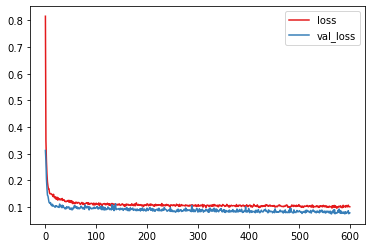

In [66]:
model1_loss = pd.DataFrame(model.history.history)
model1_loss.plot()

As expected the training had better behavior with early stopping now finally we can try the model with both dropout layers and early stopping callbacks to combat overfitting better.

In [59]:
model = Sequential()
model.add(Dense(16,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(8,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy',optimizer = 'adam')

In [60]:
model.fit(x=X_train,y=y_train,epochs=600,validation_data =(X_val,y_val),
         callbacks=[early_stop])

Epoch 1/600
223/223 [==============================] - 1s 1ms/step - loss: 0.8155 - val_loss: 0.3121
Epoch 2/600
223/223 [==============================] - 0s 965us/step - loss: 0.3491 - val_loss: 0.2743
Epoch 3/600
223/223 [==============================] - 0s 948us/step - loss: 0.2739 - val_loss: 0.2056
Epoch 4/600
223/223 [==============================] - 0s 934us/step - loss: 0.2249 - val_loss: 0.1705
Epoch 5/600
223/223 [==============================] - 0s 923us/step - loss: 0.1943 - val_loss: 0.1444
Epoch 6/600
223/223 [==============================] - 0s 990us/step - loss: 0.1785 - val_loss: 0.1411
Epoch 7/600
223/223 [==============================] - 0s 949us/step - loss: 0.1681 - val_loss: 0.1285
Epoch 8/600
223/223 [==============================] - 0s 951us/step - loss: 0.1680 - val_loss: 0.1184
Epoch 9/600
223/223 [==============================] - 0s 1ms/step - loss: 0.1533 - val_loss: 0.1153
Epoch 10/600
223/223 [==============================] - 0s 959us/step - loss:

223/223 [==============================] - 0s 890us/step - loss: 0.1133 - val_loss: 0.0995
Epoch 81/600
223/223 [==============================] - 0s 879us/step - loss: 0.1135 - val_loss: 0.1001
Epoch 82/600
223/223 [==============================] - 0s 883us/step - loss: 0.1165 - val_loss: 0.0967
Epoch 83/600
223/223 [==============================] - 0s 931us/step - loss: 0.1140 - val_loss: 0.1024
Epoch 84/600
223/223 [==============================] - 0s 1ms/step - loss: 0.1157 - val_loss: 0.1017
Epoch 85/600
223/223 [==============================] - 0s 1ms/step - loss: 0.1097 - val_loss: 0.0963
Epoch 86/600
223/223 [==============================] - 0s 974us/step - loss: 0.1159 - val_loss: 0.1010
Epoch 87/600
223/223 [==============================] - 0s 956us/step - loss: 0.1098 - val_loss: 0.0890
Epoch 88/600
223/223 [==============================] - 0s 896us/step - loss: 0.1101 - val_loss: 0.0998
Epoch 89/600
223/223 [==============================] - 0s 883us/step - loss: 0.1

223/223 [==============================] - 0s 880us/step - loss: 0.1031 - val_loss: 0.0953
Epoch 159/600
223/223 [==============================] - 0s 850us/step - loss: 0.1057 - val_loss: 0.0903
Epoch 160/600
223/223 [==============================] - 0s 887us/step - loss: 0.1111 - val_loss: 0.0895
Epoch 161/600
223/223 [==============================] - 0s 875us/step - loss: 0.1071 - val_loss: 0.0986
Epoch 162/600
223/223 [==============================] - 0s 900us/step - loss: 0.1099 - val_loss: 0.0891
Epoch 163/600
223/223 [==============================] - 0s 893us/step - loss: 0.1088 - val_loss: 0.0867
Epoch 164/600
223/223 [==============================] - 0s 882us/step - loss: 0.1099 - val_loss: 0.0937
Epoch 165/600
223/223 [==============================] - 0s 885us/step - loss: 0.1068 - val_loss: 0.0862
Epoch 166/600
223/223 [==============================] - 0s 868us/step - loss: 0.1065 - val_loss: 0.0871
Epoch 167/600
223/223 [==============================] - 0s 847us/ste

223/223 [==============================] - 0s 914us/step - loss: 0.1075 - val_loss: 0.0909
Epoch 237/600
223/223 [==============================] - 0s 869us/step - loss: 0.1045 - val_loss: 0.0911
Epoch 238/600
223/223 [==============================] - 0s 871us/step - loss: 0.1057 - val_loss: 0.0906
Epoch 239/600
223/223 [==============================] - 0s 863us/step - loss: 0.1099 - val_loss: 0.0893
Epoch 240/600
223/223 [==============================] - 0s 876us/step - loss: 0.1061 - val_loss: 0.0847
Epoch 241/600
223/223 [==============================] - 0s 875us/step - loss: 0.1070 - val_loss: 0.0843
Epoch 242/600
223/223 [==============================] - 0s 881us/step - loss: 0.1092 - val_loss: 0.0873
Epoch 243/600
223/223 [==============================] - 0s 869us/step - loss: 0.1047 - val_loss: 0.0881
Epoch 244/600
223/223 [==============================] - 0s 886us/step - loss: 0.1063 - val_loss: 0.0896
Epoch 245/600
223/223 [==============================] - 0s 889us/ste

223/223 [==============================] - 0s 900us/step - loss: 0.1053 - val_loss: 0.0857
Epoch 315/600
223/223 [==============================] - 0s 893us/step - loss: 0.1052 - val_loss: 0.0837
Epoch 316/600
223/223 [==============================] - 0s 864us/step - loss: 0.1045 - val_loss: 0.0889
Epoch 317/600
223/223 [==============================] - 0s 879us/step - loss: 0.0983 - val_loss: 0.0921
Epoch 318/600
223/223 [==============================] - 0s 864us/step - loss: 0.1040 - val_loss: 0.0862
Epoch 319/600
223/223 [==============================] - 0s 871us/step - loss: 0.1070 - val_loss: 0.0886
Epoch 320/600
223/223 [==============================] - 0s 840us/step - loss: 0.1058 - val_loss: 0.0849
Epoch 321/600
223/223 [==============================] - 0s 883us/step - loss: 0.1068 - val_loss: 0.0814
Epoch 322/600
223/223 [==============================] - 0s 905us/step - loss: 0.1044 - val_loss: 0.0915
Epoch 323/600
223/223 [==============================] - 0s 886us/ste

223/223 [==============================] - 0s 979us/step - loss: 0.1029 - val_loss: 0.0844
Epoch 393/600
223/223 [==============================] - 0s 907us/step - loss: 0.1036 - val_loss: 0.0866
Epoch 394/600
223/223 [==============================] - 0s 934us/step - loss: 0.1009 - val_loss: 0.0839
Epoch 395/600
223/223 [==============================] - 0s 893us/step - loss: 0.1045 - val_loss: 0.1007
Epoch 396/600
223/223 [==============================] - 0s 926us/step - loss: 0.1035 - val_loss: 0.0808
Epoch 397/600
223/223 [==============================] - 0s 911us/step - loss: 0.1087 - val_loss: 0.0833
Epoch 398/600
223/223 [==============================] - 0s 922us/step - loss: 0.1061 - val_loss: 0.0855
Epoch 399/600
223/223 [==============================] - 0s 912us/step - loss: 0.1017 - val_loss: 0.0813
Epoch 400/600
223/223 [==============================] - 0s 939us/step - loss: 0.1014 - val_loss: 0.0845
Epoch 401/600
223/223 [==============================] - 0s 907us/ste

223/223 [==============================] - 0s 887us/step - loss: 0.1031 - val_loss: 0.0848
Epoch 471/600
223/223 [==============================] - 0s 869us/step - loss: 0.1023 - val_loss: 0.0808
Epoch 472/600
223/223 [==============================] - 0s 846us/step - loss: 0.1020 - val_loss: 0.0798
Epoch 473/600
223/223 [==============================] - 0s 854us/step - loss: 0.1059 - val_loss: 0.0893
Epoch 474/600
223/223 [==============================] - 0s 860us/step - loss: 0.1050 - val_loss: 0.0784
Epoch 475/600
223/223 [==============================] - 0s 873us/step - loss: 0.1051 - val_loss: 0.0795
Epoch 476/600
223/223 [==============================] - 0s 854us/step - loss: 0.1081 - val_loss: 0.0811
Epoch 477/600
223/223 [==============================] - 0s 884us/step - loss: 0.1055 - val_loss: 0.0801
Epoch 478/600
223/223 [==============================] - 0s 888us/step - loss: 0.0992 - val_loss: 0.0788
Epoch 479/600
223/223 [==============================] - 0s 876us/ste

223/223 [==============================] - 0s 960us/step - loss: 0.1064 - val_loss: 0.0837
Epoch 549/600
223/223 [==============================] - 0s 923us/step - loss: 0.1015 - val_loss: 0.0792
Epoch 550/600
223/223 [==============================] - 0s 941us/step - loss: 0.1039 - val_loss: 0.0820
Epoch 551/600
223/223 [==============================] - 0s 938us/step - loss: 0.1008 - val_loss: 0.0851
Epoch 552/600
223/223 [==============================] - 0s 949us/step - loss: 0.1009 - val_loss: 0.0772
Epoch 553/600
223/223 [==============================] - 0s 928us/step - loss: 0.1052 - val_loss: 0.0789
Epoch 554/600
223/223 [==============================] - 0s 964us/step - loss: 0.1027 - val_loss: 0.0793
Epoch 555/600
223/223 [==============================] - 0s 892us/step - loss: 0.0985 - val_loss: 0.0848
Epoch 556/600
223/223 [==============================] - 0s 937us/step - loss: 0.1014 - val_loss: 0.0835
Epoch 557/600
223/223 [==============================] - 0s 923us/ste

<AxesSubplot:>

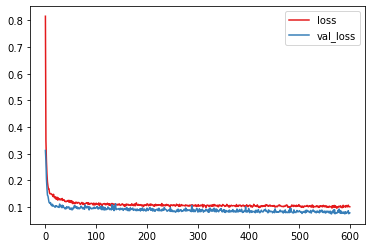

In [61]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

So adding the dropout layers took a longer training time and the results are almost identical. Let us compare them with a confusion matrix.

In [68]:
predictions1 = model1.predict(X_test)
predictions = model.predict(X_test)

In [81]:
predictions1 = np.where(predictions1 > 0.5, 1,0)

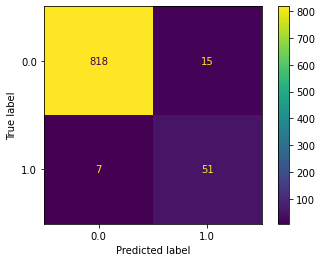

In [82]:
cm = sk.metrics.confusion_matrix(y_test,predictions1, labels=None, sample_weight=None, normalize=None)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=featuremodel.classes_)
disp.plot()
plt.show()

In [87]:
print(classification_report(y_test,predictions1))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       833
         1.0       0.77      0.88      0.82        58

    accuracy                           0.98       891
   macro avg       0.88      0.93      0.90       891
weighted avg       0.98      0.98      0.98       891



For model with dropout and early stopping:

In [83]:
predictions = np.where(predictions > 0.5, 1,0)

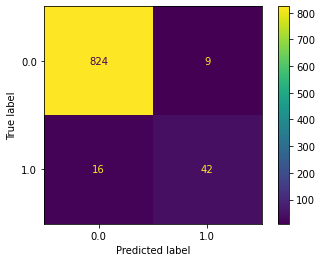

In [84]:
cm = sk.metrics.confusion_matrix(y_test,predictions, labels=None, sample_weight=None, normalize=None)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=featuremodel.classes_)
disp.plot()
plt.show()

In [85]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       833
         1.0       0.82      0.72      0.77        58

    accuracy                           0.97       891
   macro avg       0.90      0.86      0.88       891
weighted avg       0.97      0.97      0.97       891



## Conclusion and Future Steps

From our conclusion we can see that the model is able to predict a good amount of NBA All-Stars, especially the one with model with only early_stopping, For better results we can implement a hyperparameter optimised network with the best activation functions, number of neurons and hidden layers, etc.